In [910]:
# Standard library imports
from datetime import datetime
import os

# Third-party library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Visualize loop progress
import xlwings as xw # dynamic Excel interaction
from lightweight_charts import Chart
import mplfinance as mpf
import matplotlib.pyplot as plt

# Set pandas display options for better data frame visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Segreti
from dotenv import load_dotenv
load_dotenv()

# API
import requests
import json

| Gap-Up Screener |
|--|
TradingView Data (import)

In [911]:
# today's date string for file naming automation
today_date_str = datetime.now().strftime("_%Y-%m-%d.csv")
# today_date_str = '_2024-03-07.csv'

print(today_date_str)

_2024-03-13.csv


In [912]:
# concat base file name with today's date string
filename = f"trading_view_raw_data/tv_screen_gap-up{today_date_str}"
# read in trading view raw data
trading_view_raw_df = pd.read_csv(filename)

print(f'{len(trading_view_raw_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
trading_view_raw_df.head(5)

1136 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower"
0,MSFT,Microsoft Corporation,NASDAQ,3085711467608.9995,USD,415.28,USD,415.99,USD,3.08,USD,0.741668,0.170969,7318827360.76,22456969,38577755,122683,20511079.5,22851085.63333334,24654685.33333333,2.716389,2.238736,1.523403,412.546667,37.55912705,Technology Services,0.70794701,1.0122284,1.0291758,0.8906199,4.439959,3.915402,2.771495,1.912760,1.018511,0.590615,0.789381,1.1371213,0.35259876,0.30117471,420.740,USD,420.82,USD,420.82,USD,420.82,USD,420.82000,USD,415.57,USD,415.570,USD,415.5700,USD,415.5700,USD,415.5700,USD,415.57,USD,415.570,USD,415.570,USD,417.350,USD,958891.40271493,USD,415.32400,415.286875,414.99300,415.006669,415.512203,415.097600,414.682997,415.462477,414.994585,414.526693
1,AMZN,"Amazon.com, Inc.",NASDAQ,1821842722586,USD,175.39,USD,175.38,USD,0.83,USD,0.473231,-0.005702,9234336275.6,36610494,65095381,179166,35771898.60000006,47212759.06666667,47027001.66666668,2.791022,2.545484,1.911044,174.710000,60.69698228,Retail Trade,0.68342432,1.1478652,1.3817025,1.1703976,4.010038,4.893946,3.845179,1.759921,0.880668,0.454421,0.550196,1.03933203,0.2945744,0.24508298,180.140,USD,180.14,USD,180.14,USD,180.14,USD,188.65391,USD,175.76,USD,175.940,USD,175.9400,USD,175.9400,USD,175.9400,USD,176.05,USD,176.760,USD,176.760,USD,180.140,USD,376908.19672131,USD,175.56394,175.629350,175.69200,175.723815,176.036629,175.756130,175.475631,175.971299,175.715230,175.459161
2,GOOG,Alphabet Inc.,NASDAQ,1728321992309.9998,USD,139.62,USD,139.60,USD,0.20,USD,0.143246,-0.014325,5274001645,19019696,41556061,77185,28201691.79999998,25388559.93333337,22308989.75555557,1.497721,2.499190,1.955769,139.370000,24.05085096,Technology Services,0.398516,1.0631686,1.1586931,1.0489115,3.802944,5.537850,4.033052,2.541021,1.012352,0.507881,0.575384,0.66651303,0.38534749,0.44723422,150.590,USD,155.20,USD,155.20,USD,155.20,USD,155.20000,USD,139.82,USD,139.965,USD,140.0500,USD,140.0500,USD,140.0500,USD,140.17,USD,140.280,USD,140.280,USD,140.280,USD,1683033.61059057,USD,139.67700,139.732250,139.83910,139.885900,140.112586,139.855375,139.598164,140.140917,139.910320,139.679723
3,GOOGL,Alphabet Inc.,NASDAQ,1728321992309.9998,USD,138.50,USD,138.48,USD,0.18,USD,0.129964,-0.0

In [913]:
def categorize_market_cap(df):
    # convert 'Market capitalization' to numeric, coercing errors to NaN
    df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
    # define conditions for market cap categories
    conditions = [
        # Titans
        (df['Market capitalization'] >= 200000000000),  # 200 billion and above
        #Large Cap
        (df['Market capitalization'] >= 10000000000) & (df['Market capitalization'] < 200000000000),  # 10 billion to 200 billion
        # Midlers
        (df['Market capitalization'] >= 2000000000) & (df['Market capitalization'] < 10000000000),  # 2 billion to 10 billion
        # Small Cap
        (df['Market capitalization'] >= 300000000) & (df['Market capitalization'] < 2000000000),  # 300 million to 2 billion
        # Micro Cap
        (df['Market capitalization'] > 50000000) & (df['Market capitalization'] < 300000000),  # 300 million and below (excluding 50 million and below)
        # Shrimp
        (df['Market capitalization'] <= 50000000)  # 50 million and below
    ]
    categories = ['Titans', 'Large caps', 'Midlers', 'Small caps', 'Micro caps', 'Shrimp']
    # use np.select to assign categories based on conditions
    df['marketCapType'] = np.select(conditions, categories, default='Undefined')
    
    return df


In [914]:
# EXECUTE
trading_view_raw_df = categorize_market_cap(trading_view_raw_df)
trading_view_raw_df.head(5)

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,MSFT,Microsoft Corporation,NASDAQ,3.085711e+12,USD,415.28,USD,415.99,USD,3.08,USD,0.741668,0.170969,7318827360.76,22456969,38577755,122683,20511079.5,22851085.63333334,24654685.33333333,2.716389,2.238736,1.523403,412.546667,37.55912705,Technology Services,0.70794701,1.0122284,1.0291758,0.8906199,4.439959,3.915402,2.771495,1.912760,1.018511,0.590615,0.789381,1.1371213,0.35259876,0.30117471,420.740,USD,420.82,USD,420.82,USD,420.82,USD,420.82000,USD,415.57,USD,415.570,USD,415.5700,USD,415.5700,USD,415.5700,USD,415.57,USD,415.570,USD,415.570,USD,417.350,USD,958891.40271493,USD,415.32400,415.286875,414.99300,415.006669,415.512203,415.097600,414.682997,415.462477,414.994585,414.526693,Titans
1,AMZN,"Amazon.com, Inc.",NASDAQ,1.821843e+12,USD,175.39,USD,175.38,USD,0.83,USD,0.473231,-0.005702,9234336275.6,36610494,65095381,179166,35771898.60000006,47212759.06666667,47027001.66666668,2.791022,2.545484,1.911044,174.710000,60.69698228,Retail Trade,0.68342432,1.1478652,1.3817025,1.1703976,4.010038,4.893946,3.845179,1.759921,0.880668,0.454421,0.550196,1.03933203,0.2945744,0.24508298,180.140,USD,180.14,USD,180.14,USD,180.14,USD,188.65391,USD,175.76,USD,175.940,USD,175.9400,USD,175.9400,USD,175.9400,USD,176.05,USD,176.760,USD,176.760,USD,180.140,USD,376908.19672131,USD,175.56394,175.629350,175.69200,175.723815,176.036629,175.756130,175.475631,175.971299,175.715230,175.459161,Titans
2,GOOG,Alphabet Inc.,NASDAQ,1.728322e+12,USD,139.62,USD,139.60,USD,0.20,USD,0.143246,-0.014325,5274001645,19019696,41556061,77185,28201691.79999998,25388559.93333337,22308989.75555557,1.497721,2.499190,1.955769,139.370000,24.05085096,Technology Services,0.398516,1.0631686,1.1586931,1.0489115,3.802944,5.537850,4.033052,2.541021,1.012352,0.507881,0.575384,0.66651303,0.38534749,0.44723422,150.590,USD,155.20,USD,155.20,USD,155.20,USD,155.20000,USD,139.82,USD,139.965,USD,140.0500,USD,140.0500,USD,140.0500,USD,140.17,USD,140.280,USD,140.280,USD,140.280,USD,1683033.61059057,USD,139.67700,139.732250,139.83910,139.885900,140.112586,139.855375,139.598164,140.140917,139.910320,139.679723,Titans
3,GOOGL,Alphabet Inc.,NASDAQ,1.728322e+12,USD,138.50,USD,138.48,USD,0.18,U

In [915]:
# drop NaNs
tv_df = trading_view_raw_df.dropna()
print(f'NaNs = {tv_df.isna().sum().sum()}')

# confirm no NaNs
if tv_df.isna().sum().sum() == 0:
    nan_count = tv_df.isna().sum().sum()
    print(f"There are zero {nan_count} NaNs in DataFrame! Nice work!")
else:
    print(f"There are {tv_df.isna().sum().sum()} NaNs in DataFrame, check your code dumb dumb!")

NaNs = 0
There are zero 0 NaNs in DataFrame! Nice work!


In [916]:
# view the raw counts and percentages of each market cap type
market_cap_type_df = trading_view_raw_df['marketCapType'].value_counts().reset_index()
market_cap_type_df.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage -> add new columne to dataframe
market_cap_type_df['percentage'] = (market_cap_type_df['count'] / market_cap_type_df['count'].sum()) * 100

print(f'There are still the same {len(trading_view_raw_df.index)} U.S. Stocks in the dataframe \n$(pre-market change) > $0.00 USD')
market_cap_type_df

There are still the same 1136 U.S. Stocks in the dataframe 
$(pre-market change) > $0.00 USD


,marketCapType,count,percentage
0,Small caps,277,24.383803
1,Shrimp,232,20.422535
2,Midlers,209,18.397887
3,Micro caps,197,17.341549
4,Large caps,191,16.813380
5,Titans,22,1.936620
6,Undefined,8,0.704225


In [917]:
# print length of df
print(f'{len(tv_df.index)} U.S. Stocks \n$(pre-market change) > $0.00 USD')
# print sample head
tv_df.sample(5)

1128 U.S. Stocks 
$(pre-market change) > $0.00 USD


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
91,SPOT,Spotify Technology S.A.,NYSE,5.009086e+10,USD,258.0900,USD,259.2900,USD,1.2000,USD,0.464954,0.464954,137636103.018168,1351010,3840464,100,1848475.9,2224996.86666667,1818064.23333333,2.073307,3.016796,2.636108,257.593667,-,Technology Services,0.42733099,1.1066877,1.7315016,1.6320705,3.852159,10.856042,10.247013,5.222176,1.482528,0.621534,0.610391,0.72387028,0.40302788,0.40340188,272.4400,USD,272.4400,USD,272.440000,USD,272.44,USD,387.44,USD,258.7800,USD,258.8925,USD,258.8925,USD,258.8925,USD,258.8925,USD,258.9300,USD,259.736,USD,259.736,USD,272.4400,USD,-,-,258.59700,258.617188,258.47300,258.288846,258.982520,258.557965,258.133410,258.786292,258.225375,257.664458,Large caps
408,HBM,Hudbay Minerals Inc.,NYSE,2.240973e+09,USD,6.3900,USD,6.4900,USD,0.0500,USD,0.782473,1.564945,349897598.4,2459635,4929528,4023,2433285,2130065.83333333,2036718.72222222,3.691814,3.553747,3.236416,6.360000,34.05381942,Non-Energy Minerals,0.60937291,1.8577459,1.8624197,1.9631921,1.763769,5.345827,8.561385,5.927813,2.405242,1.362946,0.950529,0.99704474,0.54578758,0.40917476,6.5200,USD,6.5200,USD,6.520000,USD,6.52,USD,28.89,USD,6.4100,USD,6.4200,USD,6.4275,USD,6.4275,USD,6.4275,USD,6.4400,USD,6.460,USD,6.460,USD,6.5200,USD,-,-,6.38826,6.394088,6.40702,6.415777,6.432740,6.405590,6.378440,6.441486,6.417505,6.393524,Midlers
196,JNPR,"Juniper Networks, Inc.",NYSE,1.195345e+10,USD,36.8500,USD,36.9695,USD,0.1195,USD,0.324288,0.324288,320121877.47,3991408,8244487,100,3298423.3,3452988.1,4447113.23333333,1.032889,0.710792,0.689365,36.936667,38.69578914,Technology Services,1.00015551,0.7582691,0.894459,0.97891074,5.125606,3.660253,2.972720,3.434680,1.651878,0.979678,1.665219,1.29489595,0.31121903,0.28707724,37.6900,USD,38.0400,USD,38.040000,USD,38.04,USD,244.50,USD,36.8700,USD,36.9000,USD,36.9400,USD,36.9400,USD,36.9400,USD,36.9600,USD,37.170,USD,37.340,USD,37.6900,USD,499326.99210337,USD,36.86300,36.863125,36.87700,36.863462,36.923645,36.881625,36.839605,36.927704,36.868725,36.809746,Large caps
1105,OBLG,Oblong Inc.,NASDAQ,2.629489e+06,USD,0.1576,USD,0.1558,USD,0.0026,USD,1.649746,-1.142132,16553592.5208,229613,415594,5675,212062.89999999,657861.46

In [918]:
# drop undefined
tv_df = tv_df[tv_df['marketCapType'] != 'Undefined']

market_cap_type_df2 = tv_df['marketCapType'].value_counts().reset_index()
market_cap_type_df2.columns = ['marketCapType', 'count']  # Rename columns for clarity

# calculate percentage for each market cap type and add it to the DataFrame
market_cap_type_df2['percentage'] = (market_cap_type_df2['count'] / market_cap_type_df2['count'].sum()) * 100

market_cap_type_df2
print(market_cap_type_df2)


  marketCapType  count  percentage
0    Small caps    277   24.556738
1        Shrimp    232   20.567376
2       Midlers    209   18.528369
3    Micro caps    197   17.464539
4    Large caps    191   16.932624
5        Titans     22    1.950355


In [919]:
# 1/3 #### CONFIG DATA SECTION ####
criteria_config = {
    "Titans": {
        "pre_market_change_pct_threshold": 0.002,  # Reduced to 0.2% for Titans
        "float_shares_outstanding_threshold": 1000000000,  # Increased to 1 billion shares
        "relative_volume_threshold": 1.2,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.03,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.001,  # Reduced to 0.1%
        "pre_market_vmap_drawdown_threshold": 0.003  # .3% drawdown from VWAP
    },
    "Large caps": {
        "pre_market_change_pct_threshold": 0.005,  # Reduced to 0.5% for Large caps
        "float_shares_outstanding_threshold": 200000000,  # Increased to 200 million shares
        "relative_volume_threshold": 1.3,  # Slightly more inclusive
        "relative_volume_at_time_threshold": 0.04,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.005,  # Reduced to 0.5%
        "pre_market_vmap_drawdown_threshold": 0.004  # .4% drawdown from VWAP
    },
    "Midlers": {
        "pre_market_change_pct_threshold": 0.02,  # 2% for Mid caps
        "float_shares_outstanding_threshold": 50000000,  # 50 million shares
        "relative_volume_threshold": 1.3,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .02,
        "pre_market_vmap_drawdown_threshold": 0.005  # .5% drawdown from VWAP
    },
    "Small caps": {
        "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
        "float_shares_outstanding_threshold": 20000000,  # 20 million shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .03,
        "pre_market_vmap_drawdown_threshold": 0.006  # 6% drawdown from VWAP
    },
    "Micro caps": {
        "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
        "float_shares_outstanding_threshold": 5000000,  # 5 million shares
        "relative_volume_threshold": 1.1,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .04,
        "pre_market_vmap_drawdown_threshold": 0.007  # 7% drawdown from VWAP
    },
    "Shrimp": {
        "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
        "float_shares_outstanding_threshold": 1000000,  # 1 million shares
        "relative_volume_threshold": 1.0,
        "relative_volume_at_time_threshold": .05,
        "pre_market_gap_percentage_threshold": .05,
        "pre_market_vmap_drawdown_threshold": 0.008  # 8% drawdown from VWAP
    }
}

# 2/3 #### CORE FUNCTIONS ####
def filter_by_pre_market_change(df, change_pct_threshold):
    """Filter stocks by pre-market change percentage."""
    return df[df['Pre-market Change %'] >= change_pct_threshold]

def filter_by_float_shares(df, float_shares_threshold):
    """Filter stocks by float shares outstanding."""
    # create a copy to safely modify without affecting the original DataFrame
    modified_df = df.copy()
    modified_df['Float shares outstanding'] = pd.to_numeric(modified_df['Float shares outstanding'], errors='coerce')
    return modified_df[modified_df['Float shares outstanding'] <= float_shares_threshold]

def filter_by_relative_volume(df, relative_volume_threshold):
    """Filter stocks by relative volume."""
    df['Relative Volume 1 day'] = pd.to_numeric(df['Relative Volume 1 day'], errors='coerce')
    return df[df['Relative Volume 1 day'] >= relative_volume_threshold]

def filter_by_relative_volume_at_time(df, relative_volume_at_time_threshold):
    """Filter stocks by relative volume at a specific time."""
    # Convert 'Relative Volume at Time' to float
    df['Relative Volume at Time'] = pd.to_numeric(df['Relative Volume at Time'], errors='coerce')
    return df[df['Relative Volume at Time'] >= relative_volume_at_time_threshold]

def filter_by_pre_market_gap_percentage(df, pre_market_gap_percentage_threshold):
    """Filter stocks by pre-market gap percentage."""
    return df[df['Pre-market Gap %'] >= pre_market_gap_percentage_threshold]

def filter_by_price_near_vwap(df, pre_market_vmap_drawdown_threshold):
    """
    Filter stocks where the price is near the VWAP, considering the specified drawdown threshold.
    """
    df_filtered = df.copy()
    df_filtered['Price'] = pd.to_numeric(df_filtered['Price'], errors='coerce')
    df_filtered['Volume Weighted Average Price 1 day'] = pd.to_numeric(df_filtered['Volume Weighted Average Price 1 day'], errors='coerce')
    
    # Calculate the acceptable minimum price based on the VWAP drawdown threshold
    df_filtered['Min Price from VWAP'] = df_filtered['Volume Weighted Average Price 1 day'] * (1 - pre_market_vmap_drawdown_threshold)
    
    # Apply the filter
    df_filtered = df_filtered[df_filtered['Price'] >= df_filtered['Min Price from VWAP']]
    
    return df_filtered.drop(columns=['Min Price from VWAP'])

"""SPECIAL FILTERS"""
def filter_by_volatility(df):
    """Filter stocks based on recent volatility being higher than weekly and monthly averages."""
    # Ensure data types are correct; convert to numeric if necessary
    df['Volatility 1 day'] = pd.to_numeric(df['Volatility 1 day'], errors='coerce')
    df['Volatility 1 week'] = pd.to_numeric(df['Volatility 1 week'], errors='coerce')
    df['Volatility 1 month'] = pd.to_numeric(df['Volatility 1 month'], errors='coerce')
    filtered_df = df[
        (df['Volatility 1 day'] >= df['Volatility 1 week']) & 
        (df['Volatility 1 day'] >= df['Volatility 1 month'])]
    return filtered_df

# 3/3 #### WRAPPER FUNCTION ####
def screen_stocks_by_category(df, category):
    """Screen stocks based on their market cap category."""
    # 3a. Get the configuration for the specified category
    config = criteria_config.get(category, {})
    pre_market_change_pct_threshold = config.get("pre_market_change_pct_threshold", 0)
    float_shares_threshold = config.get("float_shares_outstanding_threshold", float('inf'))
    relative_volume_threshold = config.get("relative_volume_threshold", 0)
    relative_volume_at_time_threshold = config.get("relative_volume_at_time_threshold", 0)
    pre_market_gap_percentage_threshold = config.get("pre_market_gap_percentage_threshold", 0)
    pre_market_vmap_drawdown_threshold = config.get("pre_market_vmap_drawdown_threshold", 0)
    # 3b. Apply the filters
    filtered_df = filter_by_pre_market_change(df, pre_market_change_pct_threshold)
    filtered_df = filter_by_float_shares(filtered_df, float_shares_threshold)
    filtered_df = filter_by_relative_volume(filtered_df, relative_volume_threshold)
    filtered_df = filter_by_relative_volume_at_time(filtered_df, relative_volume_at_time_threshold)
    filtered_df = filter_by_volatility(filtered_df) # SPECIAL FILTER
    # filtered_df = filter_by_price_above_vwap(filtered_df) # SPECIAL FILTER
    filtered_df = filter_by_pre_market_gap_percentage(filtered_df, pre_market_gap_percentage_threshold)
    filtered_df = filter_by_price_near_vwap(filtered_df, pre_market_vmap_drawdown_threshold)
  
    # 3c. Return the filtered DataFrame
    return filtered_df

In [920]:
#EXECUTE
tv_L2_df = pd.DataFrame()
categories = tv_df['marketCapType'].unique()

for category in categories:
    category_df = tv_df[tv_df['marketCapType'] == category]
    screened_df = screen_stocks_by_category(category_df, category)
    tv_L2_df = pd.concat([tv_L2_df, screened_df])

# Display results
print(f'Original DataFrame length: {len(tv_df.index)}')
print(f'Number of rows removed: {len(tv_df.index) - len(tv_L2_df.index)}')
print(f'NEW DataFrame length: {len(tv_L2_df.index)}')

# filter in descending order by market cap and then by pre-market change percentage
tv_L2_df = tv_L2_df.sort_values(by=['Market capitalization', 'Pre-market Change %'], ascending=[False, False])
# reset index and drop
tv_L2_df = tv_L2_df.reset_index(drop=True)

Original DataFrame length: 1128
Number of rows removed: 1124
NEW DataFrame length: 4


In [921]:
# create a breakdown of the market cap types
market_cap_type_df3 = tv_L2_df['marketCapType'].value_counts().reset_index()
market_cap_type_df3.columns = ['marketCapType', 'count']  # Rename columns for clarity
# calculate percentage for each market cap type and add it to the DataFrame
market_cap_type_df3['percentage'] = (market_cap_type_df3['count'] / market_cap_type_df3['count'].sum()) * 100

print('Returned Gap-Up Market Cap Type Groups:')
market_cap_type_df3

Returned Gap-Up Market Cap Type Groups:


,marketCapType,count,percentage
0,Midlers,3,75.0
1,Small caps,1,25.0


In [922]:
# market cap type groups
print(f"Market Cap Groups:\n{tv_L2_df['marketCapType'].unique()}\n")

# TradingView column names
tv_raw_columns_list = tv_L2_df.columns.tolist()
print(f'TradingView Column Names (raw data):\n{tv_raw_columns_list}\n')

# stocks returned from the pre-market gap up screener
print(f'{len(tv_L2_df.index)} = U.S. stocks returned from the pre-market gap up screener.')

# create a list of 'Symbols' from the tv_L2_df
gap_up_stocks_list = tv_L2_df['Symbol']
gap_up_stocks_list = gap_up_stocks_list.tolist()
print(gap_up_stocks_list)

# FILTERD DATAFRAME WITH GAP-UP STOCK TARGETS
tv_L2_df


Market Cap Groups:
['Midlers' 'Small caps']

TradingView Column Names (raw data):
['Symbol', 'Description', 'Exchange', 'Market capitalization', 'Market capitalization - Currency', 'Price', 'Price - Currency', 'Pre-market Open', 'Pre-market Open - Currency', 'Pre-market Change', 'Pre-market Change - Currency', 'Pre-market Change %', 'Pre-market Gap %', 'Float shares outstanding', 'Volume 1 day', 'Volume 1 week', 'Pre-market Volume', 'Average Volume 10 days', 'Average Volume 30 days', 'Average Volume 90 days', 'Volatility 1 day', 'Volatility 1 week', 'Volatility 1 month', 'Volume Weighted Average Price 1 day', 'Price to earnings ratio', 'Sector', 'Relative Volume at Time', 'Beta 1 year', 'Beta 3 years', 'Beta 5 years', 'Relative Volume 1 minute', 'Relative Volume 5 minutes', 'Relative Volume 15 minutes', 'Relative Volume 30 minutes', 'Relative Volume 1 hour', 'Relative Volume 2 hours', 'Relative Volume 4 hours', 'Relative Volume 1 day', 'Relative Volume 1 week', 'Relative Volume 1 month

,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,PPC,Pilgrim's Pride Corporation,NASDAQ,7.904077e+09,USD,33.38,USD,33.50,USD,0.12,USD,0.359497,0.359497,4.090967e+07,1379236,2332077,270,926686.2,799847.23333333,703561.65555556,2.656489,2.289256,2.340457,33.250000,24.64014173,Process Industries,1.075145,0.68148583,0.6066818,0.81960094,4.991516,3.740428,4.172256,4.356717,2.104161,1.711917,2.026118,1.396645,0.70510603,0.39453076,33.62,USD,33.62,USD,33.62,USD,33.62,USD,38.6400,USD,33.49,USD,33.490,USD,33.62,USD,33.62,USD,33.62,USD,33.62,USD,33.62,USD,33.62,USD,33.62,USD,283649.80392157,USD,33.4260,33.441450,33.44800,33.465769,33.502778,33.432830,33.362882,33.590250,33.432500,33.274750,Midlers
1,ITRI,"Itron, Inc.",NASDAQ,4.171497e+09,USD,91.52,USD,91.75,USD,0.23,USD,0.251311,0.251311,4.506268e+07,852780,1394358,271,559071,469752.56666667,380865.37777778,3.251308,3.077919,3.217879,91.353333,43.38263178,Electronic Technology,0.763768,1.5433061,1.5750945,1.4103701,0.966749,4.952543,6.864931,2.680826,1.306107,0.950493,1.037304,1.413700,0.75969225,0.51849807,96.73,USD,96.73,USD,96.73,USD,96.73,USD,122.3100,USD,91.60,USD,92.015,USD,92.06,USD,92.06,USD,92.06,USD,92.48,USD,92.73,USD,95.75,USD,96.73,USD,370990.44205496,USD,91.3850,91.412500,91.73100,91.957500,92.105709,91.640500,91.175291,92.463986,91.969375,91.474764,Midlers
2,PAY,"Paymentus Holdings, Inc.",NYSE,2.965466e+09,USD,23.93,USD,24.40,USD,0.47,USD,1.964062,1.964062,1.649416e+07,1438710,2299186,6800,795070.2,340992.73333333,214308.18888889,16.166505,11.103245,5.164183,22.863333,134.58942632,Commercial Services,1.439815,1.4165473,1.4026895,1.4026895,2.606430,4.427288,2.549021,1.378952,0.965617,0.688696,1.208089,2.141640,2.29537636,3.4249406,24.00,USD,24.00,USD,24.00,USD,24.00,USD,39.2292,USD,24.00,USD,24.000,USD,24.00,USD,24.00,USD,24.00,USD,24.00,USD,24.00,USD,24.00,USD,24.00,USD,482710.13354281,USD,23.8929,23.889937,23.82918,23.656992,23.960174,23.848005,23.735836,23.997043,23.524260,23.051477,Midlers
3,GRND,Grindr Inc.,NYSE,1.750586e+09,USD,10.00,USD,10.10,USD,0.10,USD,1.000000,1.000000,1.353830e+07,2195762,2851262,1498,862698.9,458074.23333333,516130.5,9.880565,7.084122,4.334760,9.776667,-,Technology Services,1.983094,

| Gap-Up Screener |
|--|
IEX Cloud API (GET Request)

In [923]:
"""
A.
THIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))
-try to get foreign news where people are awake
-translation (internationalization) feature would be both advanced as well as practical
-all info about these companies so we start to learn what we are wokring with today
-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade

B.
-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.
-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?

C.
-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)

"""

"\nA.\nTHIS IS ALSO GOING TO BE YOUR NEWS, CURRENT NEWS (like almost real-time (within 15-30mins))\n-try to get foreign news where people are awake\n-translation (internationalization) feature would be both advanced as well as practical\n-all info about these companies so we start to learn what we are wokring with today\n-maybe some fundamentals although less important for gap up? unless gap up turns into swing trade\n\nB.\n-need a closeness list. some rating system. avoid if a stock barely misses one or two filter metrics.\n-so it's two part, 1-the filter closeness boolean as well as well has how close this miss was in terms of percentage and like an aggregate or miss difference -> THEN scoring system?\n\nC.\n-you are going to need also a -> 'chart_tv_df (this will be for the TradingView data)\n\n"

In [924]:
# """NEWS AND THAT INTERNATIONALIZATION SHIT GOES HERE"""
# info_news_df = pd.DataFrame(tv_L2_df, columns=['Symbol', 'Exchange', 'marketCapType'])

# info_news_df

In [925]:
# # manual add list
# manual_add_list = ['DELL','PLTR','TSLA']
# # append list with manually added stocks
# gap_up_stocks_list.extend(manual_add_list)

# print(f'{manual_add_list} added manually\n')
# print(f'New list: {gap_up_stocks_list}')

In [926]:
#### IEX CLOUD API KEY -> VARIABLE ####
iex_api_key = os.getenv("IEX_API_KEY")

# set the list of symbols variable
symbols = ','.join(gap_up_stocks_list)

# SETTING THE DATE RANGE
"""
y - Example: range=1y -> returns (one year)
ytd - Example: range=ytd -> returns (year-to-date)
m - Example: range=6m returns (six months)
d - Example: range=5d returns (five days)
"""
data_range = '5m' # DATE RANGE (for historical stock price data)

url = f'https://cloud.iexapis.com/stable/stock/market/batch?symbols={symbols}&types=chart&range={data_range}&token={iex_api_key}'

# Make the GET request
response = requests.get(url)

# Initialize a list to collect DataFrames for each symbol
dataframes_list = []

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to JSON
    data = response.json()

    # Process and print the data with a progress bar
    for symbol in tqdm(gap_up_stocks_list, desc="Processing symbols"):
        if symbol in data:
            # Create a DataFrame for the current symbol's data
            symbol_df = pd.DataFrame(data[symbol]['chart'])
            # Add a 'Ticker' column to identify the data
            symbol_df['Ticker'] = symbol
            # Append the current symbol's DataFrame to the list
            dataframes_list.append(symbol_df)
            # print(f'Data for {symbol}:')
            # print(symbol_df.head(5))  # print the first few rows of the DataFrame for this symbol
else:
    print(f'Failed to fetch data: {response.status_code}')

# concatenate dataframes and create a combined list
historical_df = pd.concat(dataframes_list, ignore_index=True)


Processing symbols: 100%|██████████| 4/4 [00:00<00:00, 1304.71it/s]


In [927]:
# Set variables for historical data analysis
historical_length = len(historical_df.index)
unique_stocks = historical_df['Ticker'].nunique()
start_date = historical_df['date'].min()
end_date = historical_df['date'].max()

print(f"START date: {start_date}")
print(f"END date: {end_date}")
print(f'{historical_df["date"].nunique()} days of historical stock data.\n')
print(f"{historical_length} = Length of dataframe")
print(f"{unique_stocks} = Unique stocks in dataframe")

# Entries per stock
days_per_stock = historical_length / unique_stocks
print(f"{days_per_stock} = Date entries per stock (MATH check -> should be the same as the unique )\n")

# View the stocks
print(f'Unique stock ticker symbols: {gap_up_stocks_list}')
historical_cols_list = historical_df.columns.tolist()
print(f'Columns: {historical_cols_list}')

# convert df to .csv
# historical_df.to_csv(f'historical_stock_data{today_date_str}.csv', index=False)

# Display the first few rows of the dataframe
historical_df.head()

START date: 2023-10-13
END date: 2024-03-12
103 days of historical stock data.

412 = Length of dataframe
4 = Unique stocks in dataframe
103.0 = Date entries per stock (MATH check -> should be the same as the unique )

Unique stock ticker symbols: ['PPC', 'ITRI', 'PAY', 'GRND']
Columns: ['close', 'high', 'low', 'open', 'priceDate', 'symbol', 'volume', 'id', 'key', 'subkey', 'date', 'updated', 'changeOverTime', 'marketChangeOverTime', 'uOpen', 'uClose', 'uHigh', 'uLow', 'uVolume', 'fOpen', 'fClose', 'fHigh', 'fLow', 'fVolume', 'label', 'change', 'changePercent', 'Ticker']


,close,high,low,open,priceDate,symbol,volume,id,key,subkey,date,updated,changeOverTime,marketChangeOverTime,uOpen,uClose,uHigh,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume,label,change,changePercent,Ticker
0,24.01,24.070,23.195,23.51,2023-10-13,PPC,1061401,HISTORICAL_PRICES,PPC,,2023-10-13,1697247021000,0.000000,0.000000,23.51,24.01,24.070,23.195,1061401,23.51,24.01,24.070,23.195,1061401,"Oct 13, 23",0.00,0.0000,PPC
1,24.27,24.380,23.780,24.06,2023-10-16,PPC,661824,HISTORICAL_PRICES,PPC,,2023-10-16,1697504434000,0.010829,0.010829,24.06,24.27,24.380,23.780,661824,24.06,24.27,24.380,23.780,661824,"Oct 16, 23",0.26,0.0108,PPC
2,24.47,24.885,24.270,24.35,2023-10-17,PPC,1136326,HISTORICAL_PRICES,PPC,,2023-10-17,1697590868000,0.019159,0.019159,24.35,24.47,24.885,24.270,1136326,24.35,24.47,24.885,24.270,1136326,"Oct 17, 23",0.20,0.0082,PPC
3,24.69,24.810,24.260,24.36,2023-10-18,PPC,832173,HISTORICAL_PRICES,PPC,,2023-10-18,1697677222000,0.028322,0.028322,24.36,24.69,24.810,24.260,832173,24.36,24.69,24.810,24.260,832173,"Oct 18, 23",0.22,0.0090,PPC
4,24.46,24.955,24.390,24.71,2023-10-19,PPC,843210,HISTORICAL_PRICES,PPC,,2023-10-19,1697763622000,0.018742,0.018742,24.71,24.46,24.955,24.390,843210,24.71,24.46,24.955,24.390,843210,"Oct 19, 23",-0.23,-0.0093,PPC


In [928]:
#### DEV - DATA ORGANIZATION ####
# convert df to .csv
# historical_df.to_csv(f'/Users/sudz4/Desktop/FINANCIAL-SYSTEMS/dark-trader/trading_view_raw_data/historical_stock_data{today_date_str}.csv', index=False)

In [929]:
# Ensure the dataframe is sorted by date if it's not already
historical_sorted_df = historical_df.sort_values(by='date')

# Select mandatory columns for a historical price bar chart + volume
# and explicitly copy the dataframe to ensure it's not a view but a new object
chart_historical_df = historical_sorted_df[[
    'symbol',   # *MANDATORY
    'date',     # *MANDATORY
    'close',    # *MANDATORY
    'high',     # *MANDATORY
    'low',      # *MANDATORY
    'open',     # *MANDATORY
    'volume'    # *MANDATORY
]].copy()

# Group by 'symbol' and get the last occurrence
last_date_df = chart_historical_df.groupby('symbol').last().reset_index()

last_date_df


,symbol,date,close,high,low,open,volume
0,GRND,2024-03-12,10.00,10.12,9.21,9.48,2195762
1,ITRI,2024-03-12,91.52,92.73,89.81,92.73,852780
2,PAY,2024-03-12,23.93,24.00,20.66,21.30,1438710
3,PPC,2024-03-12,33.38,33.62,32.75,32.77,1379236


In [930]:
# re-index the dataframe
chart_historical_df.reset_index(drop=True, inplace=True)
# view head of your main df
print(f'Length of historical data: {len(chart_historical_df.index)}')

Length of historical data: 412


In [931]:
"""
YOUR DATAFRAMES TO MOVE FORWARD WITH:
"""
#### INFO / NEWS DATAFRAME ####
print(f'1 - NEWS & STOCK INFO (trending news etc.):\n{info_news_df}\n')

#### IEX (API) - HISTORICAL DATA FRAME ####
print('2a - IEX HISTORICAL data (START):')
print(f'{chart_historical_df.head()}\n')
print('2b - IEX HISTORICAL data (END):')
print(f'{chart_historical_df.tail()}\n')

1 - NEWS & STOCK INFO (trending news etc.):
  Symbol                                        Description Exchange  \
0    EDU  New Oriental Education & Technology Group, Inc...     NYSE   
1   ONON                                      On Holding AG     NYSE   
2    MTN                                 Vail Resorts, Inc.     NYSE   
3   AFYA                                       Afya Limited   NASDAQ   
4   GRND                                        Grindr Inc.     NYSE   
5    NMM                        Navios Maritime Partners LP     NYSE   
6   PRSO                                        Peraso Inc.   NASDAQ   

  marketCapType  Market capitalization  
0    Large caps           1.497948e+10  
1    Large caps           1.047365e+10  
2       Midlers           8.495413e+09  
3    Small caps           1.941000e+09  
4    Small caps           1.636141e+09  
5    Small caps           1.337168e+09  
6        Shrimp           2.353999e+06  

2a - IEX HISTORICAL data (START):
  symbol        

In [932]:
#### TRADINGVIEW (IMPORTED) - DATAFRAME (TODAY'S DATA) ####
print('3 - TRADINGVIEW (IMPORTED) - DATAFRAME (TODAY):')
print(f'U.S. stocks returned from the pre-market gap up screener = {len(tv_L2_df.index)}')
tv_L2_df

3 - TRADINGVIEW (IMPORTED) - DATAFRAME (TODAY):
U.S. stocks returned from the pre-market gap up screener = 4


,Symbol,Description,Exchange,Market capitalization,Market capitalization - Currency,Price,Price - Currency,Pre-market Open,Pre-market Open - Currency,Pre-market Change,Pre-market Change - Currency,Pre-market Change %,Pre-market Gap %,Float shares outstanding,Volume 1 day,Volume 1 week,Pre-market Volume,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Volatility 1 day,Volatility 1 week,Volatility 1 month,Volume Weighted Average Price 1 day,Price to earnings ratio,Sector,Relative Volume at Time,Beta 1 year,Beta 3 years,Beta 5 years,Relative Volume 1 minute,Relative Volume 5 minutes,Relative Volume 15 minutes,Relative Volume 30 minutes,Relative Volume 1 hour,Relative Volume 2 hours,Relative Volume 4 hours,Relative Volume 1 day,Relative Volume 1 week,Relative Volume 1 month,New high 1 month,New high 1 month - Currency,New high 3 months,New high 3 months - Currency,New high 6 months,New high 6 months - Currency,New high 52 weeks,New high 52 weeks - Currency,New high All Time,New high All Time - Currency,High 5 minutes,High 5 minutes - Currency,High 15 minutes,High 15 minutes - Currency,High 30 minutes,High 30 minutes - Currency,High 1 hour,High 1 hour - Currency,High 2 hours,High 2 hours - Currency,High 4 hours,High 4 hours - Currency,High 1 day,High 1 day - Currency,High 1 week,High 1 week - Currency,High 1 month,High 1 month - Currency,"Revenue per employee, Annual","Revenue per employee, Annual - Currency",Simple Moving Average (5) 1 minute,Simple Moving Average (8) 1 minute,Simple Moving Average (5) 5 minutes,Simple Moving Average (13) 5 minutes,"Bollinger Bands (20) 1 minute, Upper","Bollinger Bands (20) 1 minute, Basis","Bollinger Bands (20) 1 minute, Lower","Bollinger Bands (20) 5 minutes, Upper","Bollinger Bands (20) 5 minutes, Basis","Bollinger Bands (20) 5 minutes, Lower",marketCapType
0,PPC,Pilgrim's Pride Corporation,NASDAQ,7.904077e+09,USD,33.38,USD,33.50,USD,0.12,USD,0.359497,0.359497,4.090967e+07,1379236,2332077,270,926686.2,799847.23333333,703561.65555556,2.656489,2.289256,2.340457,33.250000,24.64014173,Process Industries,1.075145,0.68148583,0.6066818,0.81960094,4.991516,3.740428,4.172256,4.356717,2.104161,1.711917,2.026118,1.396645,0.70510603,0.39453076,33.62,USD,33.62,USD,33.62,USD,33.62,USD,38.6400,USD,33.49,USD,33.490,USD,33.62,USD,33.62,USD,33.62,USD,33.62,USD,33.62,USD,33.62,USD,33.62,USD,283649.80392157,USD,33.4260,33.441450,33.44800,33.465769,33.502778,33.432830,33.362882,33.590250,33.432500,33.274750,Midlers
1,ITRI,"Itron, Inc.",NASDAQ,4.171497e+09,USD,91.52,USD,91.75,USD,0.23,USD,0.251311,0.251311,4.506268e+07,852780,1394358,271,559071,469752.56666667,380865.37777778,3.251308,3.077919,3.217879,91.353333,43.38263178,Electronic Technology,0.763768,1.5433061,1.5750945,1.4103701,0.966749,4.952543,6.864931,2.680826,1.306107,0.950493,1.037304,1.413700,0.75969225,0.51849807,96.73,USD,96.73,USD,96.73,USD,96.73,USD,122.3100,USD,91.60,USD,92.015,USD,92.06,USD,92.06,USD,92.06,USD,92.48,USD,92.73,USD,95.75,USD,96.73,USD,370990.44205496,USD,91.3850,91.412500,91.73100,91.957500,92.105709,91.640500,91.175291,92.463986,91.969375,91.474764,Midlers
2,PAY,"Paymentus Holdings, Inc.",NYSE,2.965466e+09,USD,23.93,USD,24.40,USD,0.47,USD,1.964062,1.964062,1.649416e+07,1438710,2299186,6800,795070.2,340992.73333333,214308.18888889,16.166505,11.103245,5.164183,22.863333,134.58942632,Commercial Services,1.439815,1.4165473,1.4026895,1.4026895,2.606430,4.427288,2.549021,1.378952,0.965617,0.688696,1.208089,2.141640,2.29537636,3.4249406,24.00,USD,24.00,USD,24.00,USD,24.00,USD,39.2292,USD,24.00,USD,24.000,USD,24.00,USD,24.00,USD,24.00,USD,24.00,USD,24.00,USD,24.00,USD,24.00,USD,482710.13354281,USD,23.8929,23.889937,23.82918,23.656992,23.960174,23.848005,23.735836,23.997043,23.524260,23.051477,Midlers
3,GRND,Grindr Inc.,NYSE,1.750586e+09,USD,10.00,USD,10.10,USD,0.10,USD,1.000000,1.000000,1.353830e+07,2195762,2851262,1498,862698.9,458074.23333333,516130.5,9.880565,7.084122,4.334760,9.776667,-,Technology Services,1.983094,

In [933]:
"""PICK UP HERE WHERE YOU LEFT OFF"""
# you need to get the chart dataframe to a place where it has all the data you need in there. 
# it would be more next level if we let it rip into live stock feeds from here. all setup with the correct lines.
# in the charts live feed we could use the tradingview html widget to display the charts.


'PICK UP HERE WHERE YOU LEFT OFF'

| KEY LEVELS (Support & Resistance) |
|-|
| TECHNICAL INDICATOR CALCULATIONS FROM HISTORICAL DATA |

in order of priority of in scope. 
thinking of moving some of the levels out as i test them and see what they look like.
for instance i am thinking of eventually completely replacing MAs with EMAs

In [934]:
"calculate key levels from historical data"
# save historical data to a csv
# chart_historical_df.to_csv(f'chart_historical_gpt_data{today_date_str}.csv', index=False)

chart_historical_df.head()

,symbol,date,close,high,low,open,volume
0,PPC,2023-10-13,24.01,24.07,23.195,23.51,1061401
1,PAY,2023-10-13,15.82,15.93,15.330,15.46,136805
2,GRND,2023-10-13,5.88,5.93,5.840,5.87,250162
3,ITRI,2023-10-13,57.54,58.71,57.440,58.48,232314
4,PPC,2023-10-16,24.27,24.38,23.780,24.06,661824


In [935]:
"""
IMPORTANT:
for effective plotting and time series analysis, it's crucial that the date column in the df is in the datetime format rather than an object (string). 
"""
chart_historical_df['date'] = pd.to_datetime(chart_historical_df['date'])
chart_historical_df.set_index('date', inplace=True)

# view the multi-indexed dataframe
chart_historical_df.head()

,symbol,close,high,low,open,volume
date,,,,,,
2023-10-13,PPC,24.01,24.07,23.195,23.51,1061401
2023-10-13,PAY,15.82,15.93,15.330,15.46,136805
2023-10-13,GRND,5.88,5.93,5.840,5.87,250162
2023-10-13,ITRI,57.54,58.71,57.440,58.48,232314
2023-10-16,PPC,24.27,24.38,23.780,24.06,661824


In [936]:
#### add VWAP to df
chart_historical_df['VWAP'] = (chart_historical_df['volume'] * (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3).cumsum() / chart_historical_df['volume'].cumsum()

chart_historical_df.head(4)

,symbol,close,high,low,open,volume,VWAP
date,,,,,,,
2023-10-13,PPC,24.01,24.07,23.195,23.51,1061401,23.758333
2023-10-13,PAY,15.82,15.93,15.330,15.46,136805,22.837513
2023-10-13,GRND,5.88,5.93,5.840,5.87,250162,19.909189
2023-10-13,ITRI,57.54,58.71,57.440,58.48,232314,25.160047


In [937]:
"""SIMPLE MOVING AVERAGES (SMA)"""
def calculate_sma(dataframe, period):
    return dataframe['close'].rolling(window=period).mean()

chart_historical_df['SMA5'] = calculate_sma(chart_historical_df, 5)
chart_historical_df['SMA10'] = calculate_sma(chart_historical_df, 10)
chart_historical_df['SMA15'] = calculate_sma(chart_historical_df, 15)

chart_historical_df.tail(10)


,symbol,close,high,low,open,volume,VWAP,SMA5,SMA10,SMA15
date,,,,,,,,,,
2024-03-08,PPC,32.39,32.45,32.060,32.33,435075,30.486297,20.410,36.271,34.894667
2024-03-08,ITRI,94.95,96.73,94.815,96.50,357522,30.616791,32.922,43.857,35.068000
2024-03-11,PAY,20.82,21.07,19.210,19.29,860476,30.567511,35.344,36.409,35.912000
2024-03-11,GRND,9.48,9.56,9.200,9.23,655500,30.490318,33.398,34.160,35.234000
2024-03-11,ITRI,92.73,95.75,92.270,94.13,541578,30.679965,50.074,41.588,39.262667
2024-03-11,PPC,32.86,33.12,32.420,32.57,952841,30.691118,50.168,35.289,40.903333
2024-03-12,ITRI,91.52,92.73,89.810,92.73,852780,30.975387,49.482,41.202,45.732000
2024-03-12,PPC,33.38,33.62,32.750,32.77,1379236,30.992496,51.994,43.669,41.604000
2024-03-12,PAY,23.93,24.00,20.660,21.30,1438710,30.929209,54.884,44.141,41.068000


In [938]:
"""EXPONENTIAL MOVING AVERAGES (EMA)"""
def calculate_ema(dataframe, period):
    return dataframe['close'].ewm(span=period, adjust=False).mean()

# calculate EMAs for the specified periods
chart_historical_df['EMA5'] = calculate_ema(chart_historical_df, 5)
chart_historical_df['EMA10'] = calculate_ema(chart_historical_df, 10)
chart_historical_df['EMA20'] = calculate_ema(chart_historical_df, 20)
chart_historical_df['EMA50'] = calculate_ema(chart_historical_df, 50)

chart_historical_df.tail(10)


,symbol,close,high,low,open,volume,VWAP,SMA5,SMA10,SMA15,EMA5,EMA10,EMA20,EMA50
date,,,,,,,,,,,,,,
2024-03-08,PPC,32.39,32.45,32.060,32.33,435075,30.486297,20.410,36.271,34.894667,25.943130,30.370993,33.738519,34.749671
2024-03-08,ITRI,94.95,96.73,94.815,96.50,357522,30.616791,32.922,43.857,35.068000,48.945420,42.112631,39.568184,37.110468
2024-03-11,PAY,20.82,21.07,19.210,19.29,860476,30.567511,35.344,36.409,35.912000,39.570280,38.241243,37.782643,36.471626
2024-03-11,GRND,9.48,9.56,9.200,9.23,655500,30.490318,33.398,34.160,35.234000,29.540187,33.011926,35.087153,35.413131
2024-03-11,ITRI,92.73,95.75,92.270,94.13,541578,30.679965,50.074,41.588,39.262667,50.603458,43.869758,40.576948,37.660852
2024-03-11,PPC,32.86,33.12,32.420,32.57,952841,30.691118,50.168,35.289,40.903333,44.688972,41.867984,39.842001,37.472583
2024-03-12,ITRI,91.52,92.73,89.810,92.73,852780,30.975387,49.482,41.202,45.732000,60.299315,50.895623,44.763715,39.592089
2024-03-12,PPC,33.38,33.62,32.750,32.77,1379236,30.992496,51.994,43.669,41.604000,51.326210,47.710964,43.679551,39.348478
2024-03-12,PAY,23.93,24.00,20.660,21.30,1438710,30.929209,54.884,44.141,41.068000,42.194140,43.387153,41.798642,38.743832


In [939]:
"""MOVING AVERAGE CONVERGENCE DIVERGENCE (MACD)"""
# calculate the MACD line and the Signal line
chart_historical_df['MACD'] = calculate_ema(chart_historical_df, 12) - calculate_ema(chart_historical_df, 26)
chart_historical_df['MACD_Signal'] = chart_historical_df['MACD'].ewm(span=9, adjust=False).mean()

# MACD Histogram -> useful for visualizing momentum and potential buy/sell signals
chart_historical_df['MACD_Histogram'] = chart_historical_df['MACD'] - chart_historical_df['MACD_Signal']

chart_historical_df.tail(10)

,symbol,close,high,low,open,volume,VWAP,SMA5,SMA10,SMA15,EMA5,EMA10,EMA20,EMA50,MACD,MACD_Signal,MACD_Histogram
date,,,,,,,,,,,,,,,,,
2024-03-08,PPC,32.39,32.45,32.060,32.33,435075,30.486297,20.410,36.271,34.894667,25.943130,30.370993,33.738519,34.749671,-2.937816,-0.448942,-2.488874
2024-03-08,ITRI,94.95,96.73,94.815,96.50,357522,30.616791,32.922,43.857,35.068000,48.945420,42.112631,39.568184,37.110468,2.344552,0.109757,2.234795
2024-03-11,PAY,20.82,21.07,19.210,19.29,860476,30.567511,35.344,36.409,35.912000,39.570280,38.241243,37.782643,36.471626,0.542937,0.196393,0.346544
2024-03-11,GRND,9.48,9.56,9.200,9.23,655500,30.490318,33.398,34.160,35.234000,29.540187,33.011926,35.087153,35.413131,-1.779387,-0.198763,-1.580624
2024-03-11,ITRI,92.73,95.75,92.270,94.13,541578,30.679965,50.074,41.588,39.262667,50.603458,43.869758,40.576948,37.660852,3.062431,0.453476,2.608955
2024-03-11,PPC,32.86,33.12,32.420,32.57,952841,30.691118,50.168,35.289,40.903333,44.688972,41.867984,39.842001,37.472583,2.045025,0.771786,1.273239
2024-03-12,ITRI,91.52,92.73,89.810,92.73,852780,30.975387,49.482,41.202,45.732000,60.299315,50.895623,44.763715,39.592089,5.904037,1.798236,4.105801
2024-03-12,PPC,33.38,33.62,32.750,32.77,1379236,30.992496,51.994,43.669,41.604000,51.326210,47.710964,43.679551,39.348478,4.222248,2.283038,1.939210
2024-03-12,PAY,23.93,24.00,20.660,21.30,1438710,30.929209,54.884,44.141,41.068000,42.194140,43.387153,41.798642,38.743832,2.102644,2.246959,-0.144315


In [940]:
#### DEV - DATA ORGANIZATION ####
chart_historical_df.columns

Index(['symbol', 'close', 'high', 'low', 'open', 'volume', 'VWAP', 'SMA5',
       'SMA10', 'SMA15', 'EMA5', 'EMA10', 'EMA20', 'EMA50', 'MACD',
       'MACD_Signal', 'MACD_Histogram'],
      dtype='object')

In [941]:
"""BOLLINGER BANDS (BB)"""
# BB 1 of 2 -> standard bollinger bands (20D CLOSE $)
period = 20 # SMA periods
std_dev_multiplier = 2 # standard deviation multiplier

# line 1: middle band -> simple moving average (SMA)
chart_historical_df[f'middle_band_SMA{period}'] = chart_historical_df['close'].rolling(window=period).mean()

# not a line: standard deviation -> used to calculate the upper and lower bands
chart_historical_df[f'std_dev_SMA{period}'] = chart_historical_df['close'].rolling(window=period).std()

# lines 2 & 3: upper and lower bands
chart_historical_df[f'upper_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] + (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)
chart_historical_df[f'lower_band_SMA{period}'] = chart_historical_df[f'middle_band_SMA{period}'] - (chart_historical_df[f'std_dev_SMA{period}'] * std_dev_multiplier)


# BB 2 of 2 -> typical price bollinger bands (20D TYPICAL $)
chart_historical_df['typical_price'] = (chart_historical_df['high'] + chart_historical_df['low'] + chart_historical_df['close']) / 3

# Calculate the SMA of the Typical Price and name it 'middle_band_typical_SMA20'
chart_historical_df[f'middle_band_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).mean()

# Calculate the standard deviation of the Typical Price
chart_historical_df[f'std_dev_typical_SMA{period}'] = chart_historical_df['typical_price'].rolling(window=period).std()

# Calculate the upper and lower bands for the Typical Price and name them accordingly
chart_historical_df[f'upper_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] + (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)
chart_historical_df[f'lower_band_typical_SMA{period}'] = chart_historical_df[f'middle_band_typical_SMA{period}'] - (chart_historical_df[f'std_dev_typical_SMA{period}'] * std_dev_multiplier)

# view df with new (2) BBs (6 new columns)
# chart_historical_df.iloc[-1] # last row slice to check the new columns
chart_historical_df.tail(2)


,symbol,close,high,low,open,volume,VWAP,SMA5,SMA10,SMA15,EMA5,EMA10,EMA20,EMA50,MACD,MACD_Signal,MACD_Histogram,middle_band_SMA20,std_dev_SMA20,upper_band_SMA20,lower_band_SMA20,typical_price,middle_band_typical_SMA20,std_dev_typical_SMA20,upper_band_typical_SMA20,lower_band_typical_SMA20
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-12,PAY,23.93,24.00,20.66,21.30,1438710,30.929209,54.884,44.141,41.068000,42.19414,43.387153,41.798642,38.743832,2.102644,2.246959,-0.144315,40.1465,33.073713,106.293927,-26.000927,22.863333,40.055388,33.154294,106.363976,-26.253200
2024-03-12,GRND,10.00,10.12,9.21,9.48,2195762,30.680827,38.338,44.206,40.504667,31.46276,37.316761,38.770200,37.616623,-0.693201,1.658927,-2.352128,39.0315,33.721709,106.474917,-28.411917,9.776667,38.934055,33.806676,106.547407,-28.679297


In [942]:
chart_historical_df.head(5)

,symbol,close,high,low,open,volume,VWAP,SMA5,SMA10,SMA15,EMA5,EMA10,EMA20,EMA50,MACD,MACD_Signal,MACD_Histogram,middle_band_SMA20,std_dev_SMA20,upper_band_SMA20,lower_band_SMA20,typical_price,middle_band_typical_SMA20,std_dev_typical_SMA20,upper_band_typical_SMA20,lower_band_typical_SMA20
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-10-13,PPC,24.01,24.07,23.195,23.51,1061401,23.758333,NaN,NaN,NaN,24.010000,24.010000,24.010000,24.010000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,23.758333,NaN,NaN,NaN,NaN
2023-10-13,PAY,15.82,15.93,15.330,15.46,136805,22.837513,NaN,NaN,NaN,21.280000,22.520909,23.230000,23.688824,-0.653333,-0.130667,-0.522667,NaN,NaN,NaN,NaN,15.693333,NaN,NaN,NaN,NaN
2023-10-13,GRND,5.88,5.93,5.840,5.87,250162,19.909189,NaN,NaN,NaN,16.146667,19.495289,21.577619,22.990438,-1.950693,-0.494672,-1.456021,NaN,NaN,NaN,NaN,5.883333,NaN,NaN,NaN,NaN
2023-10-13,ITRI,57.54,58.71,57.440,58.48,232314,25.160047,NaN,NaN,NaN,29.944444,26.412509,25.002608,24.345323,1.176112,-0.160515,1.336628,NaN,NaN,NaN,NaN,57.896667,NaN,NaN,NaN,NaN
2023-10-16,PPC,24.27,24.38,23.780,24.06,661824,24.872797,25.504,NaN,NaN,28.052963,26.022962,24.932836,24.342369,0.958469,0.063282,0.895187,NaN,NaN,NaN,NaN,24.143333,NaN,NaN,NaN,NaN


In [943]:
# drop rows that contain NAs (pulled extra data earlier for this purpose)
chart_historical_df = chart_historical_df.dropna()

# view the df
chart_historical_df.head(5)

,symbol,close,high,low,open,volume,VWAP,SMA5,SMA10,SMA15,EMA5,EMA10,EMA20,EMA50,MACD,MACD_Signal,MACD_Histogram,middle_band_SMA20,std_dev_SMA20,upper_band_SMA20,lower_band_SMA20,typical_price,middle_band_typical_SMA20,std_dev_typical_SMA20,upper_band_typical_SMA20,lower_band_typical_SMA20
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-10-19,ITRI,58.53,59.325,58.245,58.59,462667,27.168756,32.496,27.454,26.343333,34.038257,29.639238,27.222850,25.492034,2.263541,0.514483,1.749058,26.1335,20.432402,66.998303,-14.731303,58.700000,26.108500,20.395201,66.898902,-14.681902
2023-10-20,PPC,24.34,24.700,24.240,24.41,664847,26.959774,25.618,29.298,26.904667,30.805505,28.675740,26.948293,25.446856,1.734943,0.758575,0.976368,26.1500,20.430730,67.011459,-14.711459,24.426667,26.141917,20.391695,66.925306,-14.641473
2023-10-20,PAY,14.85,15.040,14.620,14.89,61018,26.875567,25.602,24.789,23.978667,25.487003,26.161969,25.796074,25.031293,0.543990,0.715658,-0.171668,26.1015,20.457676,67.016852,-14.813852,14.836667,26.099083,20.415683,66.930449,-14.732283
2023-10-20,GRND,5.85,6.140,5.800,5.86,538447,25.665867,25.606,24.792,23.982000,18.941335,22.468884,23.896448,24.279086,-1.113240,0.349878,-1.463119,26.1000,20.459238,67.018476,-14.818476,5.930000,26.101417,20.413253,66.927923,-14.725090
2023-10-20,ITRI,57.31,58.580,57.160,58.58,403010,26.992547,32.176,28.952,26.757333,31.730890,28.803632,27.078691,25.574416,1.706117,0.621126,1.084991,26.0885,20.440692,66.969883,-14.792883,57.683333,26.090750,20.395813,66.882376,-14.700876


In [944]:
# date column check data type
chart_historical_df.index

DatetimeIndex(['2023-10-19', '2023-10-20', '2023-10-20', '2023-10-20',
               '2023-10-20', '2023-10-23', '2023-10-23', '2023-10-23',
               '2023-10-23', '2023-10-24',
               ...
               '2024-03-08', '2024-03-08', '2024-03-11', '2024-03-11',
               '2024-03-11', '2024-03-11', '2024-03-12', '2024-03-12',
               '2024-03-12', '2024-03-12'],
              dtype='datetime64[ns]', name='date', length=393, freq=None)

In [945]:
# # IMPORTANT: reset index before saving to Excel (need this shit flat so we don't lose the 'date' index)
# chart_historical_df.reset_index(inplace=True)

In [946]:
# chart_historical_df.index

In [947]:
chart_historical_df.head(5)

,symbol,close,high,low,open,volume,VWAP,SMA5,SMA10,SMA15,EMA5,EMA10,EMA20,EMA50,MACD,MACD_Signal,MACD_Histogram,middle_band_SMA20,std_dev_SMA20,upper_band_SMA20,lower_band_SMA20,typical_price,middle_band_typical_SMA20,std_dev_typical_SMA20,upper_band_typical_SMA20,lower_band_typical_SMA20
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-10-19,ITRI,58.53,59.325,58.245,58.59,462667,27.168756,32.496,27.454,26.343333,34.038257,29.639238,27.222850,25.492034,2.263541,0.514483,1.749058,26.1335,20.432402,66.998303,-14.731303,58.700000,26.108500,20.395201,66.898902,-14.681902
2023-10-20,PPC,24.34,24.700,24.240,24.41,664847,26.959774,25.618,29.298,26.904667,30.805505,28.675740,26.948293,25.446856,1.734943,0.758575,0.976368,26.1500,20.430730,67.011459,-14.711459,24.426667,26.141917,20.391695,66.925306,-14.641473
2023-10-20,PAY,14.85,15.040,14.620,14.89,61018,26.875567,25.602,24.789,23.978667,25.487003,26.161969,25.796074,25.031293,0.543990,0.715658,-0.171668,26.1015,20.457676,67.016852,-14.813852,14.836667,26.099083,20.415683,66.930449,-14.732283
2023-10-20,GRND,5.85,6.140,5.800,5.86,538447,25.665867,25.606,24.792,23.982000,18.941335,22.468884,23.896448,24.279086,-1.113240,0.349878,-1.463119,26.1000,20.459238,67.018476,-14.818476,5.930000,26.101417,20.413253,66.927923,-14.725090
2023-10-20,ITRI,57.31,58.580,57.160,58.58,403010,26.992547,32.176,28.952,26.757333,31.730890,28.803632,27.078691,25.574416,1.706117,0.621126,1.084991,26.0885,20.440692,66.969883,-14.792883,57.683333,26.090750,20.395813,66.882376,-14.700876


In [948]:
# print(tv_L2_df.columns)

In [949]:
# # takes the original DataFrame and a list of stock symbols,
# # returns a dictionary of DataFrames, one for each stock symbol
# def create_symbol_dataframes(df, symbols):
#     symbol_dfs = {}
#     for symbol in symbols:
#         # Filter the DataFrame for the symbol and store it in a dictionary
#         symbol_dfs[f"{symbol}_chart_df"] = df[df['symbol'] == symbol]
    
#     return symbol_dfs


# symbols = mvp_chart_df['symbol'].unique() 
# symbol_dataframes = create_symbol_dataframes(mvp_chart_df, symbols)

# mtn_df = symbol_dataframes['MTN_chart_df']

# print(symbol_dataframes)



| CALCULATIONS - J. Welles Wilder Jr (technical indicators) |
|-|
| *displayed underneath the chart not overlayed* |
| START |

In [950]:
"""RELATIVE STRENGTH INDEX (RSI)"""
def calculate_rsi(dataframe, periods=14):
    close_delta = dataframe['close'].diff()
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)

    ma_up = up.rolling(window=periods).mean()
    ma_down = down.rolling(window=periods).mean()

    rsi = ma_up / (ma_up + ma_down) * 100
    return rsi

# Adding the RSI to your DataFrame
chart_historical_df['RSI'] = calculate_rsi(chart_historical_df)

chart_historical_df.tail(10)


,symbol,close,high,low,open,volume,VWAP,SMA5,SMA10,SMA15,EMA5,EMA10,EMA20,EMA50,MACD,MACD_Signal,MACD_Histogram,middle_band_SMA20,std_dev_SMA20,upper_band_SMA20,lower_band_SMA20,typical_price,middle_band_typical_SMA20,std_dev_typical_SMA20,upper_band_typical_SMA20,lower_band_typical_SMA20,RSI
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-08,PPC,32.39,32.45,32.060,32.33,435075,30.486297,20.410,36.271,34.894667,25.943130,30.370993,33.738519,34.749671,-2.937816,-0.448942,-2.488874,38.3445,34.134342,106.613183,-29.924183,32.300000,38.341638,34.138617,106.618872,-29.935595,44.054183
2024-03-08,ITRI,94.95,96.73,94.815,96.50,357522,30.616791,32.922,43.857,35.068000,48.945420,42.112631,39.568184,37.110468,2.344552,0.109757,2.234795,38.4330,34.285954,107.004908,-30.138908,95.498333,38.450222,34.325651,107.101524,-30.201081,58.992105
2024-03-11,PAY,20.82,21.07,19.210,19.29,860476,30.567511,35.344,36.409,35.912000,39.570280,38.241243,37.782643,36.471626,0.542937,0.196393,0.346544,38.6565,34.148720,106.953939,-29.640939,20.366667,38.649388,34.202209,107.053806,-29.755029,50.107294
2024-03-11,GRND,9.48,9.56,9.200,9.23,655500,30.490318,33.398,34.160,35.234000,29.540187,33.011926,35.087153,35.413131,-1.779387,-0.198763,-1.580624,37.5380,34.744545,107.027090,-31.951090,9.413333,37.525055,34.800137,107.125328,-32.075218,47.902265
2024-03-11,ITRI,92.73,95.75,92.270,94.13,541578,30.679965,50.074,41.588,39.262667,50.603458,43.869758,40.576948,37.660852,3.062431,0.453476,2.608955,41.7580,36.109021,113.976042,-30.460042,93.583333,41.794055,36.221701,114.237457,-30.649347,57.003581
2024-03-11,PPC,32.86,33.12,32.420,32.57,952841,30.691118,50.168,35.289,40.903333,44.688972,41.867984,39.842001,37.472583,2.045025,0.771786,1.273239,38.7130,33.999143,106.711285,-29.285285,32.800000,38.740555,34.113381,106.967317,-29.486207,51.055739
2024-03-12,ITRI,91.52,92.73,89.810,92.73,852780,30.975387,49.482,41.202,45.732000,60.299315,50.895623,44.763715,39.592089,5.904037,1.798236,4.105801,38.6715,33.930664,106.532828,-29.189828,91.353333,38.653555,33.969383,106.592322,-29.285212,49.702175
2024-03-12,PPC,33.38,33.62,32.750,32.77,1379236,30.992496,51.994,43.669,41.604000,51.326210,47.710964,43.679551,39.348478,4.222248,2.283038,1.939210,39.9325,33.197777,106.328054,-26.463054,33.250000,39.903388,33.244108,106.391605,-26.584829,50.112010
2024-03-12,PAY,23.93,24.00,20.660,21.30,1438710,30.929209,54.884,44.141,41.068000,42.194140,43.387153,41.798642,38.743832,2.102644,2.246959,-0.144315,40.1465,33.073713,106.293927,-26.000927,22.863333,40.055388,33.154294,106.363976,-26.253200,50.438162


In [951]:
"""AVERAGE TRUE RANGE (ATR)"""
def calculate_atr(dataframe, period=14):
    high_low = dataframe['high'] - dataframe['low']
    high_close = (dataframe['high'] - dataframe['close'].shift()).abs()
    low_close = (dataframe['low'] - dataframe['close'].shift()).abs()

    # Calculate the True Range (TR) as the maximum of the three measures
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)

    # Calculate the ATR by taking the rolling mean of the TR
    atr = tr.rolling(window=period).mean()
    
    return atr

# Adding the ATR to your DataFrame
chart_historical_df['ATR'] = calculate_atr(chart_historical_df)

chart_historical_df.tail(10)

,symbol,close,high,low,open,volume,VWAP,SMA5,SMA10,SMA15,EMA5,EMA10,EMA20,EMA50,MACD,MACD_Signal,MACD_Histogram,middle_band_SMA20,std_dev_SMA20,upper_band_SMA20,lower_band_SMA20,typical_price,middle_band_typical_SMA20,std_dev_typical_SMA20,upper_band_typical_SMA20,lower_band_typical_SMA20,RSI,ATR
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-08,PPC,32.39,32.45,32.060,32.33,435075,30.486297,20.410,36.271,34.894667,25.943130,30.370993,33.738519,34.749671,-2.937816,-0.448942,-2.488874,38.3445,34.134342,106.613183,-29.924183,32.300000,38.341638,34.138617,106.618872,-29.935595,44.054183,36.443564
2024-03-08,ITRI,94.95,96.73,94.815,96.50,357522,30.616791,32.922,43.857,35.068000,48.945420,42.112631,39.568184,37.110468,2.344552,0.109757,2.234795,38.4330,34.285954,107.004908,-30.138908,95.498333,38.450222,34.325651,107.101524,-30.201081,58.992105,35.021421
2024-03-11,PAY,20.82,21.07,19.210,19.29,860476,30.567511,35.344,36.409,35.912000,39.570280,38.241243,37.782643,36.471626,0.542937,0.196393,0.346544,38.6565,34.148720,106.953939,-29.640939,20.366667,38.649388,34.202209,107.053806,-29.755029,50.107294,39.512850
2024-03-11,GRND,9.48,9.56,9.200,9.23,655500,30.490318,33.398,34.160,35.234000,29.540187,33.011926,35.087153,35.413131,-1.779387,-0.198763,-1.580624,37.5380,34.744545,107.027090,-31.951090,9.413333,37.525055,34.800137,107.125328,-32.075218,47.902265,39.424279
2024-03-11,ITRI,92.73,95.75,92.270,94.13,541578,30.679965,50.074,41.588,39.262667,50.603458,43.869758,40.576948,37.660852,3.062431,0.453476,2.608955,41.7580,36.109021,113.976042,-30.460042,93.583333,41.794055,36.221701,114.237457,-30.649347,57.003581,43.848564
2024-03-11,PPC,32.86,33.12,32.420,32.57,952841,30.691118,50.168,35.289,40.903333,44.688972,41.867984,39.842001,37.472583,2.045025,0.771786,1.273239,38.7130,33.999143,106.711285,-29.285285,32.800000,38.740555,34.113381,106.967317,-29.486207,51.055739,47.299993
2024-03-12,ITRI,91.52,92.73,89.810,92.73,852780,30.975387,49.482,41.202,45.732000,60.299315,50.895623,44.763715,39.592089,5.904037,1.798236,4.105801,38.6715,33.930664,106.532828,-29.189828,91.353333,38.653555,33.969383,106.592322,-29.285212,49.702175,46.097850
2024-03-12,PPC,33.38,33.62,32.750,32.77,1379236,30.992496,51.994,43.669,41.604000,51.326210,47.710964,43.679551,39.348478,4.222248,2.283038,1.939210,39.9325,33.197777,106.328054,-26.463054,33.250000,39.903388,33.244108,106.391605,-26.584829,50.112010,45.754993
2024-03-12,PAY,23.93,24.00,20.660,21.30,1438710,30.929209,54.884,44.141,41.068000,42.194140,43.387153,41.798642,38.743832,2.102644,2.246959,-0.144315,40.1465,33.073713,106.293927,-26.000927,22.863333,40.055388,33.154294,106.363976,-26.253200,50.438162,45.675707


In [952]:
# START HERE
# see about if i should be doing a multi-index and group by if it makes the code more efficient and accurate and all that
# simple data plot soon to see what we are working with and if there are bugs

In [953]:
"""Average Directional Index (ADX)"""

'Average Directional Index (ADX)'

In [954]:
"""PARABOLIC SAR (PSAR)"""

'PARABOLIC SAR (PSAR)'

| J. Welles Wilder Jr (technical indicators) |
|-|
| END |

In [955]:
# LINE LEVELS not full calculation dataframe
# part 1 was calculations append
# part 2 is data points append
# part 3 extra - could be plotting past signals (might integrate ai in here like tensorflow)

| CHARTS |
|-|

In [956]:
# #### xlwings -> dynamic send to excel ####
# # save name for todays returend gap up stocks historical data
# chart_data_file = f'chart_data{today_date_str}.xlsx'

# # reset index before saving to Excel (need
# chart_historical_df.reset_index(inplace=True, drop=True)

# # Save the DataFrame to an Excel file
# chart_historical_df.to_excel(chart_data_file, index=False)

# # Use xlwings to open the file in Excel
# app = xw.App(visible=True)
# book = app.books.open(chart_data_file)

In [957]:
# AVAILABLE COLS
chart_historical_df.columns

Index(['symbol', 'close', 'high', 'low', 'open', 'volume', 'VWAP', 'SMA5',
       'SMA10', 'SMA15', 'EMA5', 'EMA10', 'EMA20', 'EMA50', 'MACD',
       'MACD_Signal', 'MACD_Histogram', 'middle_band_SMA20', 'std_dev_SMA20',
       'upper_band_SMA20', 'lower_band_SMA20', 'typical_price',
       'middle_band_typical_SMA20', 'std_dev_typical_SMA20',
       'upper_band_typical_SMA20', 'lower_band_typical_SMA20', 'RSI', 'ATR'],
      dtype='object')

In [958]:
def plot_symbol_technicals(chart_historical_df, symbol):
    # FILTER
    symbol_df = chart_historical_df[chart_historical_df['symbol'] == symbol].copy()
    
    # print(symbol_df.head(5))
    # DATA PREP
    add2plot = [
        # mpf.make_addplot(symbol_df['SMA5'], color='#7BAFD4', width=1.0, label='SMA5'), 
        # mpf.make_addplot(symbol_df['SMA10'], color='#003087', width=1.0, label='SMA10'), 
        mpf.make_addplot(symbol_df['VWAP'], color='#B31B1B', width=1.0, label='VWAP')
    ]
    
    # STYLE & PLOT
    mpf_style = mpf.make_mpf_style(base_mpf_style='nightclouds', rc={'text.color': 'white'})
    fig, axes = mpf.plot(symbol_df,
                         type='candle',
                         addplot=add2plot,
                         volume=True,
                         style=mpf_style,
                        #  style='yahoo',
                         figratio=(42, 12),
                         title=f'${symbol} - Historical Data (4 Months)',
                         tight_layout=True,
                         returnfig=True)

    # watermark
    fig.text(0.5, 0.5, symbol, fontsize=50, color='gray', alpha=0.5, ha='center', va='center', rotation=0, transform=fig.transFigure)

    mpf.show()


In [959]:
# print a list of the unique stock symbols
unique_symbols = chart_historical_df['symbol'].unique()
print(f'Unique stock symbols: {unique_symbols}')

Unique stock symbols: ['ITRI' 'PPC' 'PAY' 'GRND']


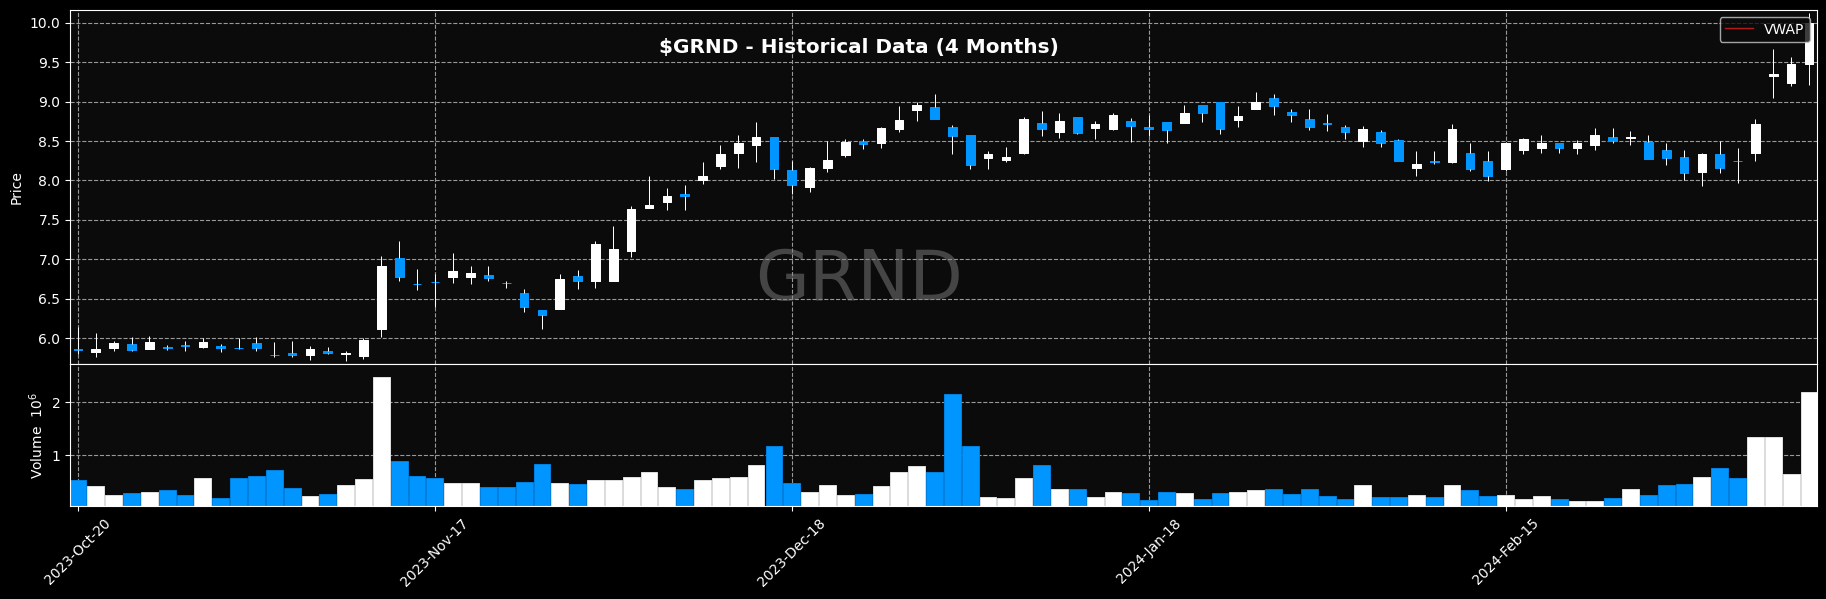

In [962]:
#### EXECUTE CHARTING ####
# DEV
plot_symbol_technicals(chart_historical_df, 'GRND')

# # PRO
# for unique in unique_symbols:
#     plot_symbol_technicals(chart_historical_df, unique)

| TREND LINES |
|-|
| Trend Lines Algorithm |

In [ ]:
# check the date column type
chart_historical_df.index

DatetimeIndex(['2023-10-16', '2023-10-17', '2023-10-17', '2023-10-17',
               '2023-10-17', '2023-10-17', '2023-10-17', '2023-10-17',
               '2023-10-17', '2023-10-17',
               ...
               '2024-03-11', '2024-03-11', '2024-03-11', '2024-03-11',
               '2024-03-11', '2024-03-11', '2024-03-11', '2024-03-11',
               '2024-03-11', '2024-03-11'],
              dtype='datetime64[ns]', name='date', length=1055, freq=None)

In [964]:
print(f'Unique stock symbols: {unique_symbols}')

Unique stock symbols: ['ITRI' 'PPC' 'PAY' 'GRND']


In [963]:
tl_pre_df = chart_historical_df[chart_historical_df['symbol'] == 'GRND']
tl_pre_df = tl_pre_df.iloc[:,:6]

tl_pre_df.head(5)

,symbol,close,high,low,open,volume
date,,,,,,
2023-10-20,GRND,5.85,6.140,5.80,5.86,538447
2023-10-23,GRND,5.86,6.060,5.76,5.82,428389
2023-10-24,GRND,5.94,5.960,5.84,5.87,247655
2023-10-25,GRND,5.85,6.008,5.84,5.92,287206
2023-10-26,GRND,5.95,6.020,5.86,5.86,302060


In [ ]:
# get the date column type
tl_pre_df.index

DatetimeIndex(['2023-10-26', '2023-11-02', '2023-11-03', '2023-11-16',
               '2023-11-20', '2023-11-22', '2023-11-28', '2023-11-29',
               '2023-11-30', '2023-12-01', '2023-12-04', '2023-12-06',
               '2023-12-07', '2023-12-08', '2023-12-11', '2023-12-12',
               '2023-12-13', '2023-12-14', '2023-12-15', '2023-12-22',
               '2023-12-29', '2024-01-04', '2024-01-08', '2024-01-09',
               '2024-01-10', '2024-01-11', '2024-01-12', '2024-01-16',
               '2024-01-17', '2024-01-19', '2024-01-22', '2024-01-23',
               '2024-01-24', '2024-01-25', '2024-01-30', '2024-01-31',
               '2024-02-01', '2024-02-02', '2024-02-05', '2024-02-06',
               '2024-02-07', '2024-02-08', '2024-02-09', '2024-02-12',
               '2024-02-13', '2024-02-14', '2024-02-15', '2024-02-16',
               '2024-02-20', '2024-02-21', '2024-02-22', '2024-02-23',
               '2024-02-26', '2024-02-27', '2024-02-28', '2024-02-29',
      

In [ ]:

# tl_pre_df.reset_index(inplace=True)
# # save to .xlsx using xlwings
# tl_pre_file = f'tl_pre_file.xlsx'
# tl_pre_df.to_excel(tl_pre_file, index=False)

# # save df to csv
# tl_pre_df.to_csv(f'tl_pre_file.csv', index=False)
# # open the file in Excel
# # app = xw.App(visible=True)
# # book = app.books.open(tl_pre_file)

In [ ]:
# # convert to the datetime type
# tl_pre_df.index = pd.to_datetime(tl_pre_df.index)

# tl_pre_df.head(5)

| END OF IN PROGRESS WORK - NOTES BELOW |
|--|

In [ ]:
""" 
ISSUE: some weird shit with the style param
nbd tho ctfo. 

workaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  
the blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style
experienced similar shit like this years ago, idunno will get to it.

"""

' \nISSUE: some weird shit with the style param\nnbd tho ctfo. \n\nworkaround =  is first successfully run with style=mpf_style, then swap it for style=s (dark mode - but common view like Ortex)  \nthe blue shit and mpf_style is actually cool but might confuse user (i.e., blue = red and white = green) with the mpf_style\nexperienced similar shit like this years ago, idunno will get to it.\n\n'

In [ ]:
# you're going to need different charts, one for the pre-market, and at least another for market open
# I'd like market opens to be a live feed but really we might already be in trading view watching the pine script execute

# Trend lines

In [ ]:
# but first start with getting lines on that chart with STRV
# let's get those key levels with an output on them and figure out your strategy
# figure out when fibonacci extensions get activated
# i see one view with a grid layout of the stock charts above or below them the summary with the key levels, current price and all that
# i also see a view where when looking at individiual stocks we got data all over that shit. idgaf if it's "confusing for the user"

# you have your key_levels_df
# so start next from there okay

#### </b> ####

# make title more symetrically bigger not just bigger for fucks sake 
# move price to the right side, keep vol on left
# see if you can get a marker or military like custom google font one of the ones you like
# better yet use that program you wrote for sn logos actually to create your shit
# could put that Sans Peur Systems somewhere at least watermark it, maybe?
# key levels find up to 6?, scoring strategy?, then base allotment of position (1/3, 1/5) conditionally?
# we could add RSI down there, fuck could add ichimoku, do whatever with all this data access now

NOTES -> SMA Legend

In [ ]:
# # SMA20, SMA50, and SMA200 has to be in 'dell_df'
# legend_info = {
#     'Indicator': ['SMA20', 'SMA50', 'SMA200'],
#     'Color': ['blue', 'orange', 'green'],
#     'Description': ['20-day Moving Average', '50-day Moving Average', '200-day Moving Average']
# }

# legend_df = pd.DataFrame(legend_info)
# print(legend_df)


NOTES -> custom mplfinance chart setup example

In [ ]:
# """    
# Custom Theme setup
# """

# dark_style = mpf.make_mpf_style(base_mpf_style='charles', 
#                                 rc={'axes.facecolor': 'black',
#                                     'figure.facecolor': 'darkslategrey',
#                                     'axes.grid': True,
#                                     'grid.color': 'gray',
#                                     'grid.linestyle': '--',
#                                     'grid.linewidth': 0.6,
#                                     'axes.titlesize': 16,
#                                     'axes.titleweight': 'bold',
#                                     'axes.labelsize': 12,
#                                     'axes.labelweight': 'bold',
#                                     'axes.labelcolor': 'white',
#                                     'axes.edgecolor': 'white',
#                                     'axes.linewidth': 2,
#                                     'xtick.color': 'white',
#                                     'xtick.labelsize': 10,
#                                     'ytick.color': 'white',
#                                     'ytick.labelsize': 10,
#                                     'figure.titlesize': 18,
#                                     'figure.titleweight': 'bold',
#                                     'legend.facecolor': 'grey',
#                                     'legend.edgecolor': 'white',
#                                     'legend.fontsize': 10,
#                                     'legend.title_fontsize': 12})

# mpf.plot(strv_df, 
#          type='candle', 
#          style=dark_style,  # Using the custom dark style
#          volume=True, 
#          title='STRV Candlestick Chart',
#          mav=(20, 50, 200),  # Adding moving averages of 20, 50, and 200 periods
#          figratio=(15, 8), 
#          tight_layout=True)

In [ ]:
# i need a math checker for trading days vs calendar days (252/365)

Notes -> yahoo finance API exaple (free) *with limitations

In [ ]:
# import yfinance as yf
# from datetime import datetime, timedelta

In [ ]:
# # yahoo finance data download
# start = datetime.now() - timedelta(days=60)
# end = datetime.now()
# yahoo_df = yf.download(gap_up_stocks_list, start, end)
# yahoo_df = yahoo_df.loc[:,'Close']
# # view the yahoo data yahoo finance formatting multi-index (has a 60day max with standard API maneuvers)
# yahoo_df.head(10)